# Nonlinear response to river levels

In [1]:
import pandas as pd
import numpy as np
import pastas as ps

import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'Prec'}, xlabel='Date'>, <Axes: >],
       [<Axes: title={'center': 'Evap'}, xlabel='Date'>, <Axes: >],
       [<Axes: title={'center': 'River'}, xlabel='Date'>,
        <Axes: xlabel='Frequency [%]'>]], dtype=object)

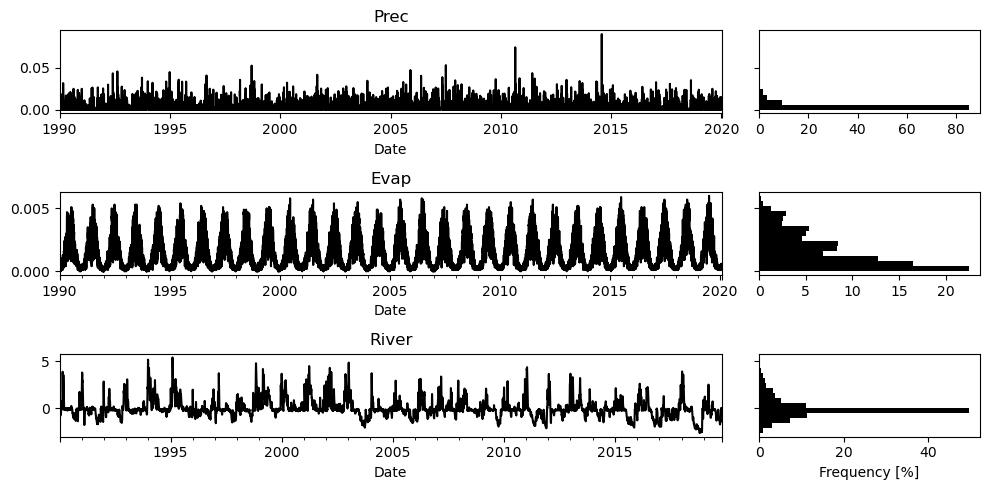

In [2]:
head = pd.read_csv("data/nb5_head.csv", parse_dates=True, index_col=0).squeeze()
rain = pd.read_csv("data/nb5_prec.csv", parse_dates=True, index_col=0).squeeze()
evap = pd.read_csv("data/nb5_evap.csv", parse_dates=True, index_col=0).squeeze()
waterlevel = pd.read_csv("data/nb5_riv.csv", parse_dates=True, index_col=0).squeeze()

ps.plots.series(stresses=[rain, evap, waterlevel])

In [72]:
rfunc = ps.rfunc.Gamma()
p0 = rfunc.get_init_parameters("river").initial.values


<Axes: xlabel='Date'>

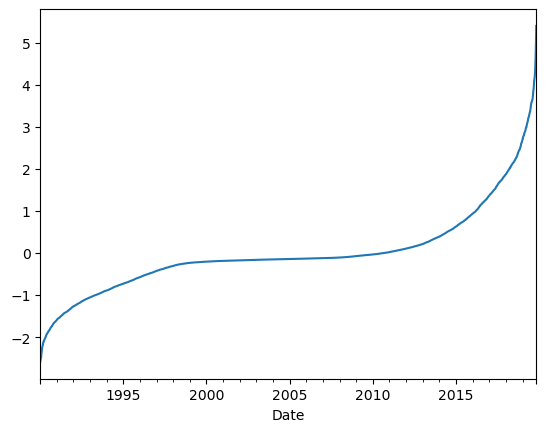

In [73]:
waterlevel.plot()

In [18]:
A_min = 0
A_max = 1

waterlevel.sort_values().values

array([-2.58971367, -2.57855609, -2.57390989, ...,  5.24244941,
        5.37267437,  5.40334893])

## Math

$$A = S a + A_0$$

where $a$ is the slope, $S$ is the stress (ie. the river level), and $A_0$ a constant that is the gain when the stress is at a minimum

In [120]:
def get_A(p, waterlevel):
    S = waterlevel.values
    a0, a = p
    A = S * a + a0
    return A

p = [-waterlevel.min(), 1]
A = get_A(p, waterlevel)
#plt.plot(waterlevel.sort_values().values, A)

n = waterlevel.index.size
r = np.zeros((n, n))

for i, pA in enumerate(A):
    p0[0] = pA
    ri = rfunc.block(p0)
    l = min(n-i, ri.size)
    r[i, i:i+l] = ri[:l]

r.sum(axis=0)

#r = np.vstack(r)


array([0.23499886, 0.45454894, 0.64942597, ..., 2.17928041, 2.19932823,
       2.21022742])

In [178]:
def get_A(p, stress):
    S = stress.values
    a0, a = p
    A = a0 + S * a
    return A

def simulate(p, stress):
    A = get_A(p[:2], stress)

    n = stress.index.size
    r = np.zeros((n, n))
    
    for i, pA in enumerate(A):
        p[2] = pA
        ri = rfunc.block(p[2:]) * stress.iloc[i]
        l = min(n-i, ri.size)
        r[i, i:i+l] = ri[:l]

    s = pd.Series(index=stress.index, data=r.sum(axis=0))
    
    return s
    

<Axes: xlabel='Date'>

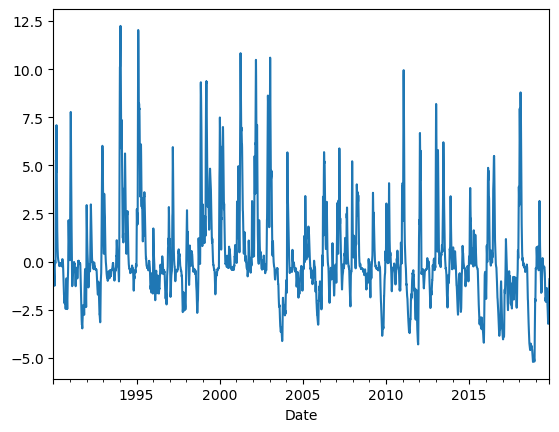

In [180]:
p1 = rfunc.get_init_parameters("river").initial.values
p = np.concatenate([[-waterlevel.min(), 1/waterlevel.max()], p1])

s = simulate(p, waterlevel)
s.plot()

In [215]:
from pandas import Series
from typing import Optional, Union
from pastas.typing import RFunc, StressSettingsDict, ArrayLike, TimestampType
from pastas.timeseries import TimeSeries
from pastas.stressmodels import StressModelBase

class RiverModel(StressModelBase):
    """Stress model convoluting a stress with a response function.

    """

    _name = "StressModel"

    def __init__(
        self,
        stress: Series,
        rfunc: RFunc,
        name: str,
        up: bool = True,
        settings: Optional[Union[str, StressSettingsDict]] = None,
        metadata: Optional[dict] = None,
        gain_scale_factor: Optional[float] = None,
    ) -> None:
        stress = TimeSeries(stress, settings=settings, metadata=metadata)

        StressModelBase.__init__(
            self,
            name=name,
            tmin=stress.series.index.min(),
            tmax=stress.series.index.max(),
            rfunc=rfunc,
            up=up,
            gain_scale_factor=(
                stress.series.std() if gain_scale_factor is None else gain_scale_factor
            ),
        )

        self.gain_scale_factor = gain_scale_factor
        self.freq = stress.settings["freq"]
        self.stress.append(stress)
        self.set_init_parameters()

    def set_init_parameters(self) -> None:
        """Set the initial parameters (back) to their default values."""
        self.parameters = self.rfunc.get_init_parameters(self.name)
        
        self.parameters.loc[self.name + "_a0"] = (
            self.stress[0].series.mean(),
            -np.inf,
            np.inf,
            True,
            self.name,
            "uniform",
        )

        self.parameters.loc[self.name + "_slope"] = (
            0.5 / self.stress[0].series.max(),
            0,
            1 / self.stress[0].series.max(),
            True,
            self.name,
            "uniform",
        )

    def simulate(
        self,
        p: ArrayLike,
        tmin: Optional[TimestampType] = None,
        tmax: Optional[TimestampType] = None,
        freq: Optional[str] = None,
        dt: float = 1.0,
    ) -> Series:
        """Simulates the head contribution.

        Parameters
        ----------
        p: array_like
            array_like object with the values as floats representing the model
            parameters.
        tmin: str, optional
        tmax: str, optional
        freq: str, optional
        dt: int, optional

        Returns
        -------
        pandas.Series
            The simulated head contribution.
        """
        self.update_stress(tmin=tmin, tmax=tmax, freq=freq)
        stress = self.stress[0].series

        A = get_A(p[-2:], stress)

        n = stress.index.size
        r = np.zeros((n, n))
    
        for i, pA in enumerate(A):
            p[0] = pA
            ri = self.rfunc.block(p[0:self.rfunc.nparam]) * stress.iloc[i]
            l = min(n-i, ri.size)
            r[i, i:i+l] = ri[:l]
    
        h = pd.Series(data=r.sum(axis=0),  
                      index=stress.index,
                      name=self.name)
        return h

    def get_A(self, p, stress):
        S = stress.values.copy()
        a0, a = p
        A = a0 + S * a
        return A


In [216]:
 sm = RiverModel(waterlevel, rfunc=ps.Gamma(), name="river")

<Axes: xlabel='Date'>

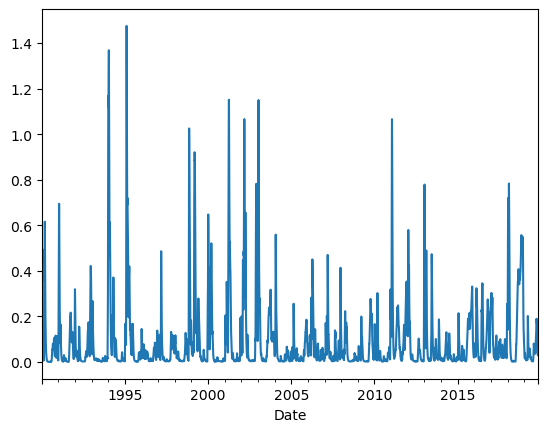

In [218]:
sm.simulate(p=sm.get_parameters()).plot()

In [226]:
ml = ps.Model(head)
sm = RiverModel(waterlevel, rfunc=ps.Gamma(), name="river")
ml.add_stressmodel(sm)
ml.solve(tmin="2000", tmax="2010")

INFO: There are observations between the simulation time steps. Linear interpolation between simulated values is used.


Fit report Head                    Fit Statistics
nfev    34                     EVP          97.97
nobs    2864                   R2            0.98
noise   False                  RMSE          0.08
tmin    2000-01-27 00:00:00    AICc     -14644.94
tmax    2010-01-01 00:00:00    BIC      -14609.21
freq    D                      Obj           8.58
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.        Yes

Parameters (6 optimized)
                  optimal       initial  vary
river_A      6.843349e-01  1.000000e+00  True
river_n      9.541734e-02  1.000000e+00  True
river_a      5.876250e+01  1.000000e+01  True
river_a0     6.843349e-01 -1.342158e-14  True
river_slope  5.345970e-12  9.253520e-02  True
constant_d   8.584802e+00  8.530099e+00  True

Warnings! (1)
Parameter 'river_slope' on lower bound: 0.00e+00


<Axes: xlabel='Date', ylabel='Head'>

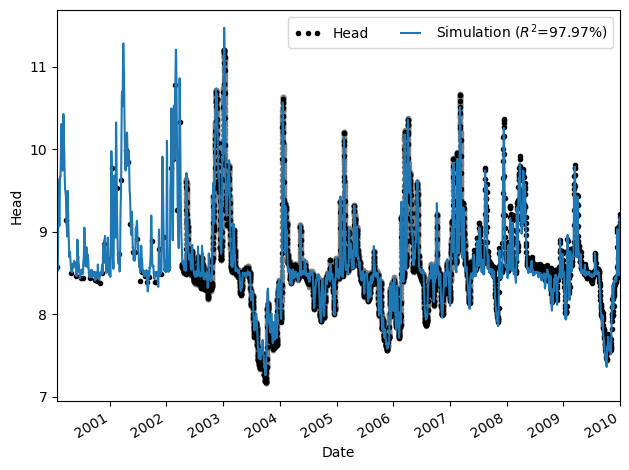

In [227]:
ml.plot()

In [4]:
ml = ps.Model(head)
sm = ps.StressModel(waterlevel, rfunc=ps.Gamma(), name="river")
ml.add_stressmodel(sm)
ml.solve(tmin="2000", tmax="2010")

INFO: There are observations between the simulation time steps. Linear interpolation between simulated values is used.


Fit report Head                    Fit Statistics
nfev    20                     EVP          97.97
nobs    2864                   R2            0.98
noise   False                  RMSE          0.08
tmin    2000-01-27 00:00:00    AICc     -14648.70
tmax    2010-01-01 00:00:00    BIC      -14624.87
freq    D                      Obj           8.58
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.        Yes

Parameters (4 optimized)
              optimal    initial  vary
river_A      0.684680   1.000000  True
river_n      0.094908   1.000000  True
river_a     59.758426  10.000000  True
constant_d   8.584784   8.530099  True


<Axes: xlabel='Date', ylabel='Head'>

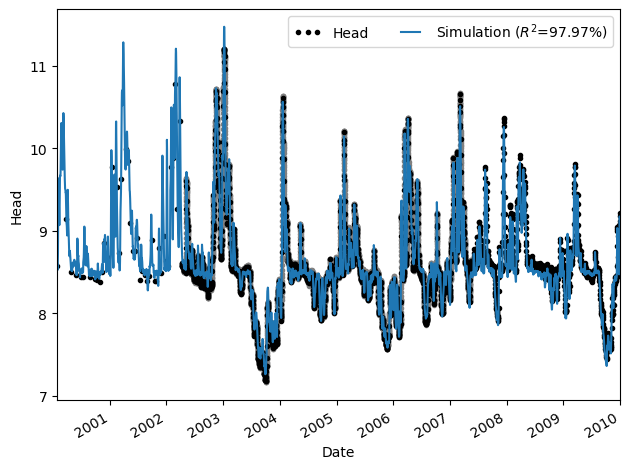

In [5]:
ml.plot()